# Kernel Based Discrepancies

Author: Jimmy Nguyen (nguyen.hoang.jimmy42@gmail.com)

This notebook walks through kernel based discrepancies using the Kronecker sequence.

One definition of discrepancy starts with a symmetric, positive definite kernel, $K:[0,1]^d\times [0,1]^d \to \mathbb{R}$, i.e.,
\begin{gather*}
K(\boldsymbol{t},\boldsymbol{x}) = K(\boldsymbol{x},\boldsymbol{t}) \qquad \forall \boldsymbol{t}, \boldsymbol{x} \in [0,1]^d \\
\sum_{i,j = 1}^{n} c_i K(\boldsymbol{x}_i,\boldsymbol{x}_j ) \boldsymbol{c}_j > 0 \qquad \forall \boldsymbol{c} \ne \boldsymbol{0}, \ \boldsymbol{x}_1, \ldots, \boldsymbol{x}_n \text{ distinct and } \in [0,1]^d
\end{gather*}
The discrepancy, $D(\{\boldsymbol{x}\}_{i=1}^n)$ is defined in terms of the kernel as
$$
[D(\{\boldsymbol{x}_i\}_{i=1}^n,K)]^2= \int_{[0,1]^d} \int_{[0,1]^d} K(\boldsymbol{t},\boldsymbol{x}) \, \mathrm{d}\boldsymbol{t} \mathrm{d}\boldsymbol{x}
- \frac{2}{n} \sum_{i=1}^n \int_{[0,1]^d} K(\boldsymbol{t}, \boldsymbol{x}_i) \, \mathrm{d}\boldsymbol{t}
+ \frac{1}{n^2} \sum_{i,j = 1}^n K(\boldsymbol{x}_i, \boldsymbol{x}_j)
$$
The discrepancy requires $\mathcal{O}(dn^2)$ operations to compute, assuming one evaluation of the kernel requires $d$ operations to compute.

We can simplify the cost to compute the discrepancy for a randomly shifted Kronecker sequence:
$$
\begin{aligned}
\text{Kronecker: } \mathbb{E}\{[D(\{i\boldsymbol{\alpha} + \boldsymbol{\Delta} \bmod \boldsymbol{1}\}_{i=1}^n,K)]^2\}
& = - \int_{[0,1]^d} \widetilde{K}(\boldsymbol{t}) \, \mathrm{d}\boldsymbol{t} + \frac{1}{n^2} \sum_{i,j = 1}^n \int_{[0,1]^d} \widetilde{K}((i - j)\boldsymbol{\alpha} \bmod \boldsymbol{1}) \\
& =  - \int_{[0,1]^d} \widetilde{K}(\boldsymbol{t}) \, \mathrm{d}\boldsymbol{t} 
+ \frac 1{n^2} \sum_{k=1-n}^{n-1}  (n -  \lvert k \rvert)\widetilde{K}(k \boldsymbol{\alpha} \bmod \boldsymbol{1}) \\
& = - \int_{[0,1]^d} \widetilde{K}(\boldsymbol{t}) \, \mathrm{d}\boldsymbol{t}
+ \frac 1{n^2} \biggl[n \widetilde{K}(\boldsymbol{0}) +  2\sum_{k=1}^{n-1}  (n - k)\widetilde{K} (k \boldsymbol{\alpha} \bmod \boldsymbol{1}) \biggr] \\
\end{aligned}
$$

$$
2\sum_{k=1}^{n-1}  (n - k)\widetilde{K} (k \boldsymbol{\alpha} \bmod \boldsymbol{1}) \\
= 2\left(n\sum_{k=1}^{n-1} \widetilde{K} (k \boldsymbol{\alpha} \bmod \boldsymbol{1}) - \sum_{k=1}^{n-1} k\widetilde{K} (k \boldsymbol{\alpha} \bmod \boldsymbol{1})\right)
$$

After splitting the above summation, we can compute the discrepancy values for n = 1,2,...,N in $\mathcal{O}(dN)$ time.
The code can be found at qmcpy/discrete_distribution/kronecker.py.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qmcpy as qp

In [2]:
def plot_discrepancy(dimension, alpha, n=1e6, gamma=None, trend=True, title=None, show=True):
    kronecker = qp.Kronecker(dimension=dimension, alpha=alpha)

    if gamma is None:
        values = kronecker.periodic_discrepancy(int(n))
    else:
        values = kronecker.periodic_discrepancy(int(n), gamma=gamma)

    x = np.arange(1, int(n) + 1)
    y = values[0] / x # multiply by values[0] to get the same starting point
    y_half = values[0] / np.sqrt(x)
    if trend:
        plt.loglog(x, y_half, label = '$O(n^{-.5})$', linestyle = '--')
        plt.loglog(x, y, label = '$O(n^{-1})$', linestyle = '--')

    plt.loglog(x, values, label="Kronecker")
    
    if title is not None:
        plt.title(title)
        
    plt.xlabel('Number of sample points')
    plt.ylabel('Discrepancy')
    plt.legend()

    if show:
        plt.show()

# Example with a Specified $\widetilde{K}$

Take $\widetilde{K}(x) = \prod_{\ell = 1}^d \left [1 + \gamma_\ell B_2(x_\ell) \right] = \prod_{\ell = 1}^d \left [1 + \gamma_\ell \left \{x_\ell(x_\ell - 1) + \frac 16 \right\}\right] $ with $d=2$ and $\gamma_\ell = 1$.

This is an example of the discrepancy when alpha is the Richtmyer alpha.

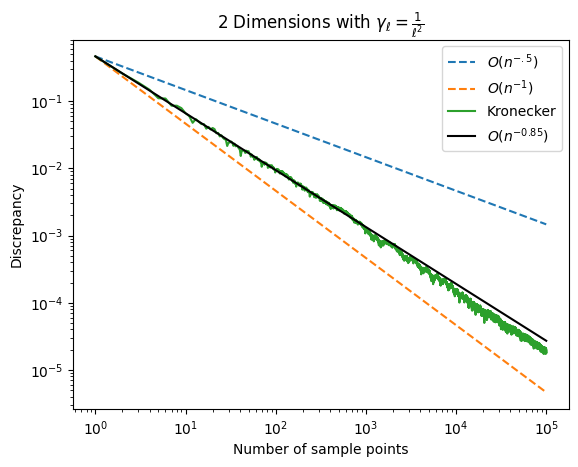

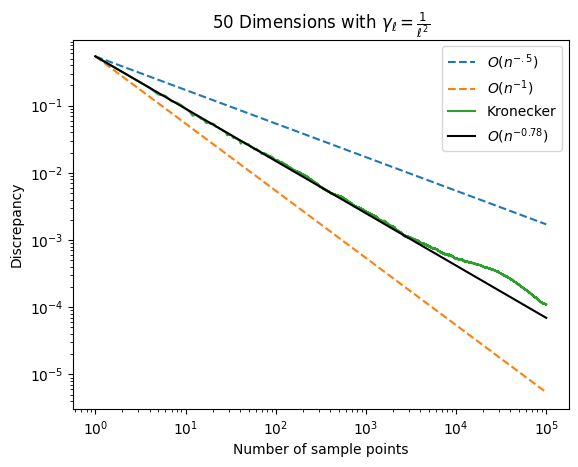

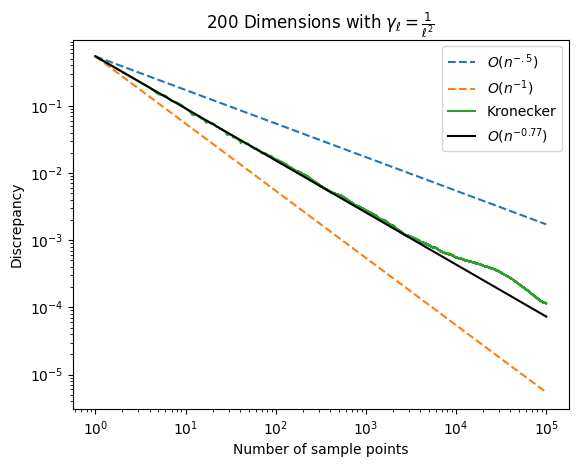

In [3]:
for d in [2, 50, 200]:
    plot_discrepancy(dimension = d,
                     alpha = 'richtmyer',
                     gamma= 1 / (np.arange(1, d + 1) ** 2), 
                     n=1e5,
                     title= str(d) + ' Dimensions with $\\gamma_\\ell = \\frac{1}{\\ell^2}$', show=False)
    

    x = np.arange(1, int(1e5) + 1)
    kronecker = qp.Kronecker(dimension=d, alpha = 'richtmyer')
    values = kronecker.periodic_discrepancy(int(1e5), gamma=1 / (np.arange(1, d+1) ** 2))
    m, b = np.polyfit(np.log10(x), np.log10(values), 1, w= 1 / (np.arange(1, int(1e5) + 1))) # ** 2))
    power = '{:.2f}'.format(m)
    plt.plot(x, 10 ** (m * np.log10(x) + b), color='black', label=f'$O(n^{{{power}}})$')
    plt.legend()
    plt.show()

We can select good choices of alpha using alpha_generate() from Kronecker.ipynb. Coordinate weights 1/$\ell^2$ were used in the search.
Since we use a component by component search, we can use the first s alphas and they should be good alphas for s dimensions.

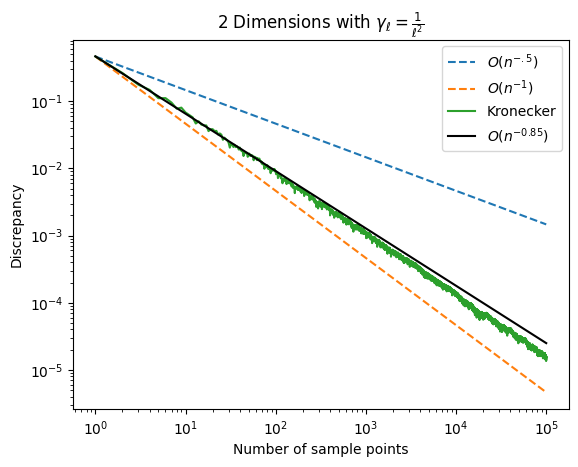

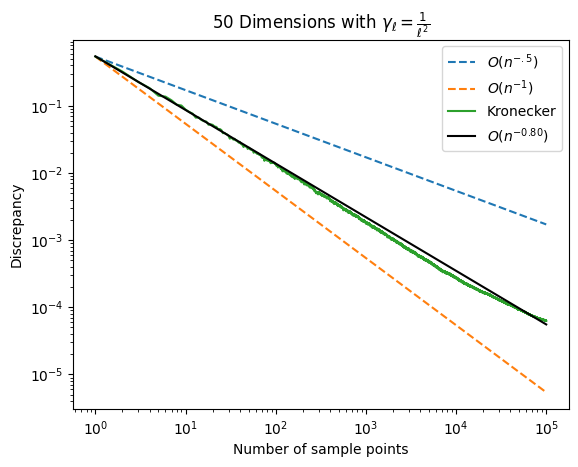

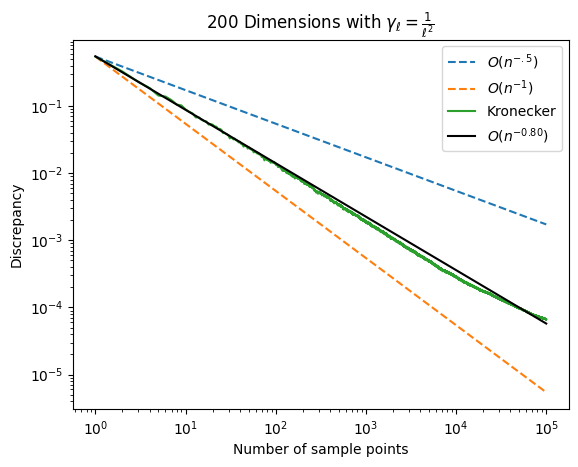

In [4]:
good_alpha = [0.38651935,0.2644145,0.18612671,0.21298985,0.43843217,0.29110027,0.45958241,0.35827278,0.41562695,0.24199866,0.15035981,0.35121004,0.44922881,0.17837129,0.43120174,0.44650028,0.17108141,0.42284971,0.46401095,0.28255744,0.108785,0.13687399,0.09861298,0.11836553,0.31141258,0.36468175,0.17001583,0.13993628,0.34498697,0.29911411,0.3130524,0.4748555,0.46568227,0.30371831,0.08634163,0.35346308,0.21813625,0.27486519,0.43212833,0.28878004,0.11979423,0.47559513,0.40557989,0.24353219,0.40998715,0.45790433,0.16355478,0.23900767,0.27561054,0.41902042,0.31694769,0.4685626,0.3146795,0.14480245,0.36543616,0.17594964,0.2986786,0.44814647,0.44770199,0.31653025,0.29684082,0.11897527,0.1464722,0.23824071,0.15550932,0.23298137,0.48093053,0.22051015,0.11609128,0.4823116,0.30940308,0.35240848,0.15193657,0.40513198,0.1548797,0.17687721,0.14074769,0.48167805,0.08241317,0.12736703,0.42205573,0.27874126,0.11212608,0.23479924,0.27178819,0.10420694,0.35218208,0.27952512,0.07379855,0.2565642,0.41868889,0.3592516,0.19613754,0.24308202,0.40840579,0.151698,0.13078879,0.30903647,0.17163202,0.41261012,0.4569076,0.22108515,0.40598709,0.27896591,0.32578062,0.30212079,0.21528937,0.13598478,0.10290032,0.08192591,0.24020265,0.14104773,0.37022326,0.36682362,0.41229459,0.3241683,0.09457838,0.35544153,0.48337414,0.46722231,0.34133511,0.219636,0.12074618,0.23697636,0.09579634,0.08714828,0.4807239,0.10557351,0.301563,0.4435941,0.3118032,0.48033347,0.13091321,0.08971655,0.43280776,0.25407764,0.10071399,0.24296168,0.37085337,0.06360134,0.45665711,0.3650539,0.12051064,0.21507578,0.35531603,0.15210812,0.08996036,0.15641997,0.2784525,0.08258728,0.48257954,0.28183156,0.31191286,0.19590777,0.23498346,0.13585994,0.40979053,0.37053156,0.23431988,0.44598849,0.09925381,0.07341532,0.11582098,0.4188285,0.30145234,0.1094012,0.1696297,0.09015355,0.36563328,0.34321232,0.25875277,0.32687492,0.11197699,0.48600676,0.25959876,0.47984483,0.41212766,0.46803772,0.43350888,0.21612062,0.27461626,0.23651233,0.44574865,0.14060214,0.4096239,0.15669923,0.480207,0.13841541,0.35976944,0.23838254,0.27210191,0.34827015,0.31734634,0.47666145,0.34336498,0.44369622,0.08939041,0.42448199,0.27821158,0.20963377,0.21886396,0.47508638,0.15513528,0.34167445,0.13945764,0.23772184,0.18111614,0.21789211,0.18905936,0.3087464,0.4364911,0.17436425,0.17472783,0.05979568,0.35406188,0.08278721,0.21097594,0.10597474,0.10189376,0.21990504,0.40589252,0.28780042,0.32384964,0.19743107,0.37782444,0.34747894,0.23230256,0.27968549,0.45632403,0.34552018,0.30243255,0.34449058,0.26006964,0.07242729,0.11469981,0.32047638,0.31789659,0.07256721,0.2340838,0.14088075,0.31749755,0.19097966,0.25696887,0.12041175,0.22135799,0.25835121,0.43530781,0.31674675,0.30419255,0.17413432,0.24435429,0.40950757,0.27697584,0.21855277,0.44605081,0.12141814,0.48535316,0.09593409,0.28414867,0.34464238,0.43462561,0.27863661,0.43016005,0.48203867,0.44850901,0.07329044,0.47598931,0.07044324,0.28938521,0.44861503,0.34738554,0.17576262,0.32525654,0.16520323,0.19655716,0.4829745,0.10750348,0.32056881,0.10276929,0.23709497,0.47682556,0.07917286,0.46841071,0.23443548,0.3144574,0.16960851,0.08943703,0.43437035,0.4103048,0.40826008,0.35397347,0.34795655,0.25625846,0.46328179,0.12721163,0.34439071,0.48626708,0.10840317,0.3166931,0.43437744,0.47438837,0.35396926,0.25968342,0.45756923,0.10931849,0.16340831,0.35380266,0.10090216,0.40274921,0.07859987,0.36246242,0.36636168,0.07862327,0.07910225,0.22027614,0.23492226,0.22125678,0.25415872,0.37667621,0.48203871,0.13946042,0.4076141,0.21639842,0.1552733,0.12709303,0.15527251,0.21992311,0.16497007,0.21682417,0.2431829,0.45632289,0.25385999,0.28113338,0.47651907,0.42448227,0.4458796,0.40826165,0.35204789,0.2378458,0.07345784,0.174134,0.28902896,0.23709582,0.4688397,0.10749466,0.31353694,0.101837,0.44039376,0.08980092,0.14424882,0.17211248,0.13417398,0.26007566,0.23774675,0.19075946,0.09763049,0.43230598,0.40950566,0.07621496,0.10931847,0.2403279,0.28414543,0.17211241,0.48602379,0.30408323,0.44369515,0.29696185,0.05962308,0.0818531,0.09593663,0.28809763,0.16515991,0.21789516,0.46837253,0.23875061,0.30243355,0.43343143,0.08278699,0.31445649,0.10065942,0.32410509,0.32056307,0.10761499,0.1633837,0.10186605,0.45702782,0.32047953,0.19581975,0.07261084,0.46884646,0.2890281,0.21097411,0.2583684,0.25993626,0.45638371,0.24435248,0.28113371,0.25385838,0.47681508,0.12141822,0.36639264,0.4853397,0.22149561,0.41030297,0.23230289,0.23491829,0.308778,0.09935442,0.32526333,0.18903414,0.32723727,0.40761332,0.21680391,0.34167849,0.42989125,0.27461935,0.0894401,0.40980042,0.47396817,0.17472877,0.410514,0.20955379,0.11575838,0.48018781,0.22122045,0.11190185,0.43531751,0.3276751,0.44789625,0.23409853,0.43454382,0.16496839,0.31749274,0.37669073,0.33978091,0.34463865,0.10774098,0.22150181,0.43454308,0.2814452,0.41030297,0.31436176,0.16390678,0.25836849,0.07610494,0.107498,0.31789877,0.08373482,0.15670223,0.47438624,0.28938445,0.18105391,0.23455321,0.35203569,0.25634737,0.17433646,0.27862373,0.09762809,0.23409927,0.32526294,0.12709726,0.42989518,0.14088107,0.40250337,0.19578812,0.0597979,0.4679587,0.07257005,0.28414727,0.3041925,0.34795867,0.08979853,0.1341709,0.32383995,0.12141801,0.44587929,0.07621769,0.22135662,0.19744131,0.1633829,0.27688389,0.07243759,0.40950439,0.27690156,0.40589315,0.37784579,0.24435444,0.10276851,0.25733152,0.18903459,0.25386187,0.16384965,0.47419887,0.07243765,0.11470237,0.13945997,0.24078907,0.30403707,0.27823972,0.25415757]
for d in [2, 50, 200]:
    plot_discrepancy(dimension=d,
                     alpha=good_alpha[:d],
                     n=int(1e5),
                     gamma= 1/ (np.arange(1, d+1) ** 2),
                     title= str(d) + ' Dimensions with $\\gamma_\\ell = \\frac{1}{\\ell^2}$',
                     show=False)
    
    x = np.arange(1, int(1e5) + 1)
    kronecker = qp.Kronecker(dimension=d, alpha=good_alpha[:d])
    values = kronecker.periodic_discrepancy(int(1e5), gamma=1/ (np.arange(1, d+1) ** 2))
    m, b = np.polyfit(np.log10(x), np.log10(values), 1, w= 1 / (np.arange(1, int(1e5) + 1))) # ** 2))

    power = '{:.2f}'.format(m)
    plt.plot(x, 10 ** (m * np.log10(x) + b), color='black', label=f'$O(n^{{{power}}})$')

    plt.legend()
    plt.show()

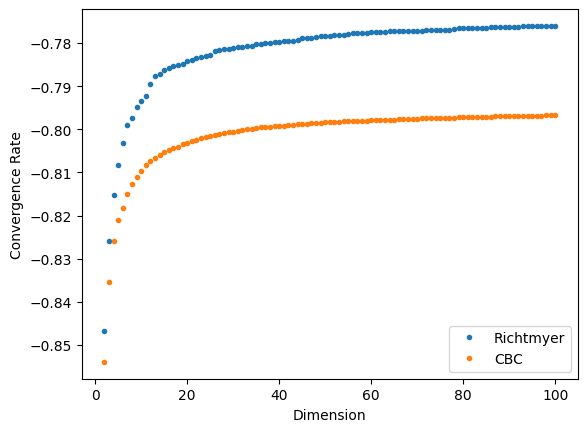

In [5]:
x = np.arange(1, int(1e5) + 1)
dimensions = np.array(range(2, 101))
richtmyer_slope = np.empty(len(dimensions))
alpha_slope = np.empty(len(dimensions))

for i, d in enumerate(dimensions):
    kronecker = qp.Kronecker(dimension=d, alpha = 'richtmyer')
    values = kronecker.periodic_discrepancy(int(1e5), gamma = 1 / (np.arange(1, d+1) ** 2))
    m, b = np.polyfit(np.log10(x), np.log10(values), 1, w = 1 / (np.arange(1, int(1e5) + 1)))
    richtmyer_slope[i] = m
    
    kronecker = qp.Kronecker(dimension=d, alpha=good_alpha[:d])
    values = kronecker.periodic_discrepancy(int(1e5), gamma = 1/ (np.arange(1, d+1) ** 2))
    m, b = np.polyfit(np.log10(x), np.log10(values), 1, w = 1 / (np.arange(1, int(1e5) + 1)))
    alpha_slope[i] = m


color1 = plt.gca()._get_lines.get_next_color()
color2 = plt.gca()._get_lines.get_next_color()
plt.plot(dimensions, richtmyer_slope, '.', label='Richtmyer', color=color1)
plt.plot(dimensions, alpha_slope, '.', label='CBC', color=color2)


plt.xlabel('Dimension')
plt.ylabel('Convergence Rate')
plt.legend()
plt.show()

Some examples with random alphas:

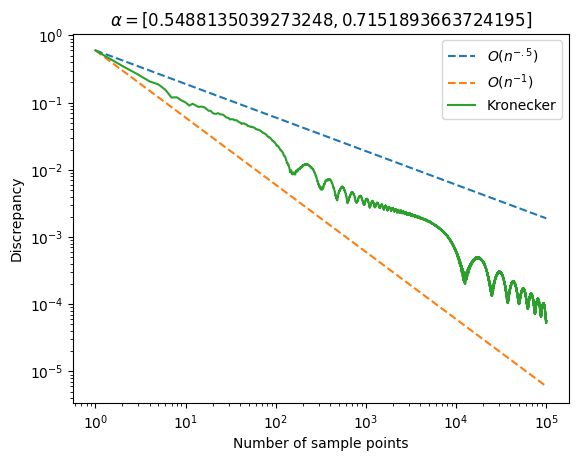

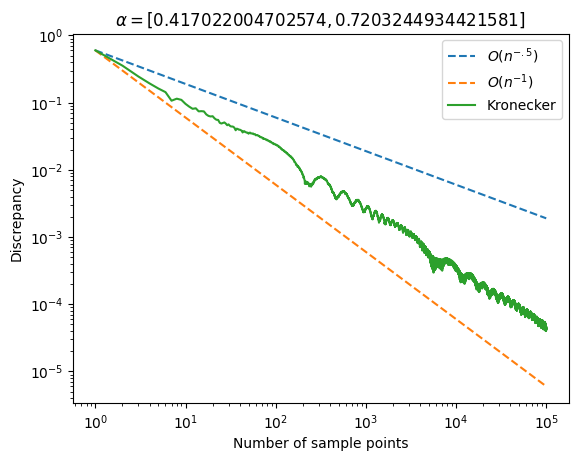

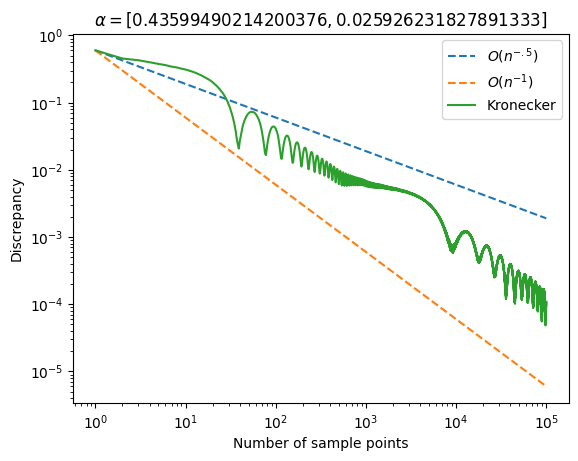

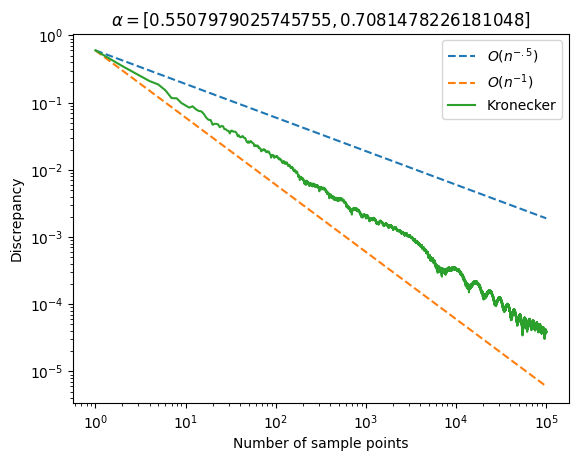

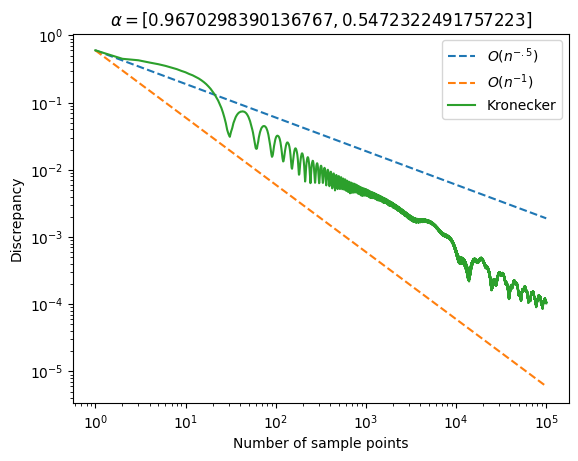

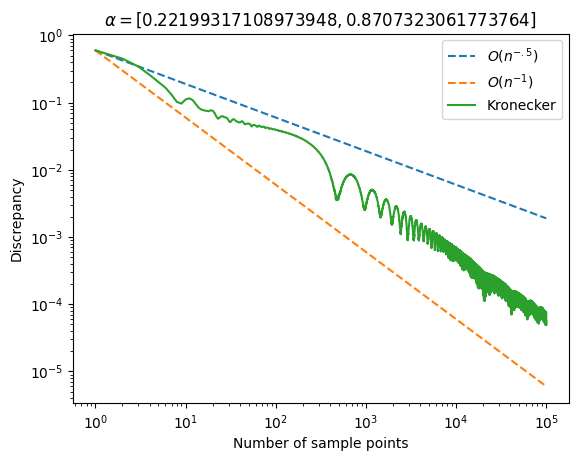

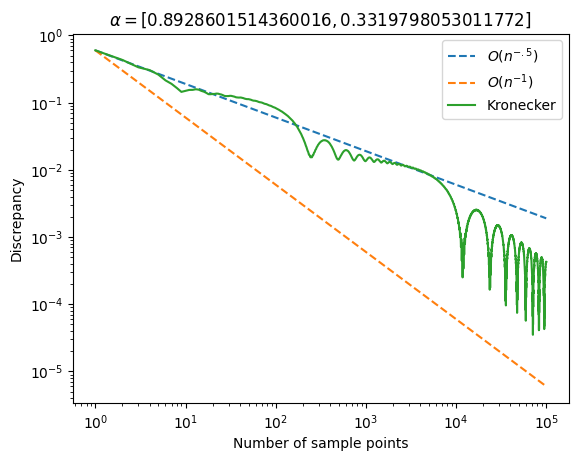

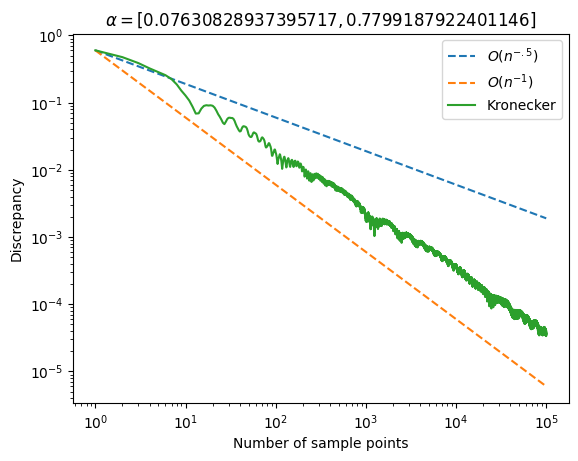

In [6]:
for i in range(8):
    np.random.seed(i)
    random = np.random.rand(2)
    plot_discrepancy(dimension=2, alpha=random, n=1e5, title=f'$\\alpha=[{random[0]}, {random[1]}]$')

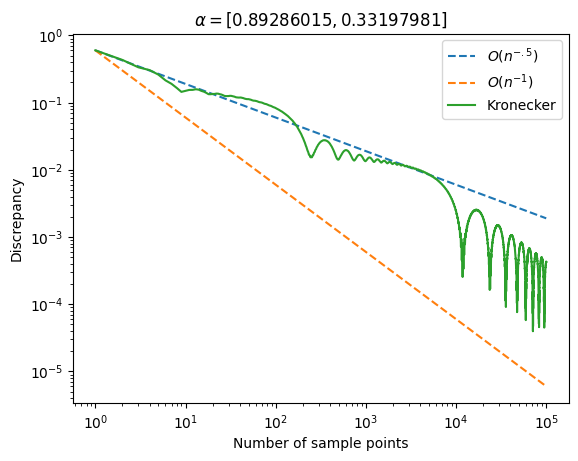

In [7]:
plot_discrepancy(2, alpha = [0.89286015, 0.33197981], n=1e5, title = '$\\alpha=[0.89286015, 0.33197981]$')